In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kunaljain10","key":"8c811a865809de9eca35677f303c9322"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download -c severstal-steel-defect-detection

100% 1.57G/1.57G [01:21<00:00, 21.3MB/s]
100% 1.57G/1.57G [01:21<00:00, 20.7MB/s]


In [6]:
! mkdir 'severstal steel defect detection'

In [7]:
! unzip severstal-steel-defect-detection.zip -d 'severstal steel defect detection'

Streaming output truncated to the last 5000 lines.
  inflating: severstal steel defect detection/train_images/99f75320d.jpg  
  inflating: severstal steel defect detection/train_images/99f9d2375.jpg  
  inflating: severstal steel defect detection/train_images/99fd3c6f5.jpg  
  inflating: severstal steel defect detection/train_images/9a016fe15.jpg  
  inflating: severstal steel defect detection/train_images/9a064450d.jpg  
  inflating: severstal steel defect detection/train_images/9a08c2783.jpg  
  inflating: severstal steel defect detection/train_images/9a18e4457.jpg  
  inflating: severstal steel defect detection/train_images/9a1f7c238.jpg  
  inflating: severstal steel defect detection/train_images/9a2523ce9.jpg  
  inflating: severstal steel defect detection/train_images/9a3e774ff.jpg  
  inflating: severstal steel defect detection/train_images/9a5e9e77c.jpg  
  inflating: severstal steel defect detection/train_images/9a5f7a855.jpg  
  inflating: severstal steel defect detection/tra

In [8]:
! pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 56.0 MB/s eta 0:00:00


In [117]:
import numpy as np # linear algebra
import pandas as pd
pd.set_option("display.max_rows", 101)
import os
import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 15
import seaborn as sns
from collections import Counter
from PIL import Image
import math
import seaborn as sns
from collections import defaultdict
from pathlib import Path
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tqdm import tqdm
import keras
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import visualkeras

In [10]:
train_df = pd.read_csv("/content/severstal steel defect detection/train.csv")
sample_df = pd.read_csv("/content/severstal steel defect detection/sample_submission.csv")

In [11]:
train_df.head()

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

In [12]:
train_df.tail()

ImageId  ClassId  \
7090  ffcf72ecf.jpg        3   
7091  fff02e9c5.jpg        3   
7092  fffe98443.jpg        3   
7093  ffff4eaa8.jpg        3   
7094  ffffd67df.jpg        3   

                                          EncodedPixels  
7090  121911 34 122167 101 122422 169 122678 203 122...  
7091  207523 3 207777 9 208030 15 208283 22 208537 2...  
7092  105929 5 106177 14 106424 24 106672 33 106923 ...  
7093  16899 7 17155 20 17411 34 17667 47 17923 60 18...  
7094  30931 43 31103 127 31275 211 31489 253 31745 2...

In [13]:
train_df.shape

(7095, 3)

In [14]:
sample_df.head()

ImageId EncodedPixels  ClassId
0  0000f269f.jpg      1 409600        0
1  000ccc2ac.jpg      1 409600        0
2  002451917.jpg      1 409600        0
3  003c5da97.jpg      1 409600        0
4  0042e163f.jpg      1 409600        0

In [15]:
train_df.ClassId.value_counts()

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

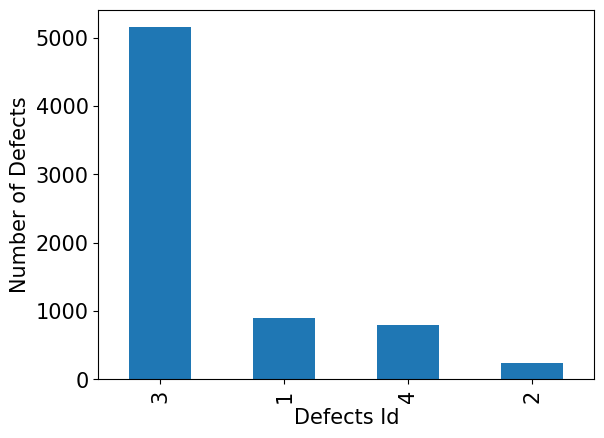

<Figure size 2000x4000 with 0 Axes>

In [16]:
train_df.ClassId.value_counts().plot.bar(xlabel='Defects Id', ylabel='Number of Defects')
plt.figure(figsize=(20,40)) 
plt.show()

In [17]:
class_by_1 = train_df[train_df['ClassId'] == 1]
class_by_2 = train_df[train_df['ClassId'] == 2]
class_by_3 = train_df[train_df['ClassId'] == 3]
class_by_4 = train_df[train_df['ClassId'] == 4]

In [18]:
print(len(class_by_1))
class_by_1.head()

897


ImageId  ClassId                                      EncodedPixels
0   0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
2   000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
8   002fc4e19.jpg        1  146021 3 146275 10 146529 40 146783 46 147038 ...
18  008ef3d74.jpg        1  356336 4 356587 11 356838 18 357089 25 357340 ...
21  00ac8372f.jpg        1  101742 3 101998 12 102253 19 102301 22 102509 ...

In [19]:
print(len(class_by_2))
class_by_2.head()

247


ImageId  ClassId                                      EncodedPixels
9   002fc4e19.jpg        2  145658 7 145901 20 146144 33 146386 47 146629 ...
19  008ef3d74.jpg        2  375439 5 375687 14 375935 24 376182 34 376430 ...
22  00ac8372f.jpg        2  98114 24 98370 72 98626 119 98881 168 99137 19...
27  00c88fed0.jpg        2  13428 8 13684 24 13940 39 14196 55 14452 71 14...
75  026183d85.jpg        2  120132 16 120388 46 120643 78 120899 108 12115...

In [20]:
print(len(class_by_3))
class_by_3.head()

5150


ImageId  ClassId                                      EncodedPixels
1   0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
4   0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...
5   0025bde0c.jpg        3  8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
11  0046839bd.jpg        3  152926 1 153180 4 153434 6 153689 8 153943 11 ...
12  005d86c25.jpg        3  331 18 587 53 843 89 1099 124 1355 159 1611 17...

In [21]:
print(len(class_by_4))
class_by_4.head()

801


ImageId  ClassId                                      EncodedPixels
3   000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
6   0025bde0c.jpg        4  315139 8 315395 15 315651 16 315906 17 316162 ...
7   002af848d.jpg        4  290800 6 291055 13 291311 15 291566 18 291822 ...
10  0030401a5.jpg        4  186833 1 187089 3 187344 6 187600 7 187855 10 ...
15  008621629.jpg        4  215548 3 215798 9 216051 12 216306 13 216560 1...

In [22]:
TRAIN_IMGS_PATH = ('/content/severstal steel defect detection/train_images/')
TEST_IMGS_PATH = ('/content/severstal steel defect detection/test_images/')
print(TRAIN_IMGS_PATH)
print(TEST_IMGS_PATH)

/content/severstal steel defect detection/train_images/
/content/severstal steel defect detection/test_images/


In [23]:
from glob import glob

In [24]:
train_fp = sorted(glob(TRAIN_IMGS_PATH + '*.jpg'))
test_fp = sorted(glob(TEST_IMGS_PATH + '*.jpg'))

In [25]:
train_fp

['/content/severstal steel defect detection/train_images/0002cc93b.jpg',
 '/content/severstal steel defect detection/train_images/00031f466.jpg',
 '/content/severstal steel defect detection/train_images/000418bfc.jpg',
 '/content/severstal steel defect detection/train_images/000789191.jpg',
 '/content/severstal steel defect detection/train_images/0007a71bf.jpg',
 '/content/severstal steel defect detection/train_images/000a4bcdd.jpg',
 '/content/severstal steel defect detection/train_images/000f6bf48.jpg',
 '/content/severstal steel defect detection/train_images/0014fce06.jpg',
 '/content/severstal steel defect detection/train_images/001982b08.jpg',
 '/content/severstal steel defect detection/train_images/001d1b355.jpg',
 '/content/severstal steel defect detection/train_images/001d3d093.jpg',
 '/content/severstal steel defect detection/train_images/0025bde0c.jpg',
 '/content/severstal steel defect detection/train_images/002af848d.jpg',
 '/content/severstal steel defect detection/train_i

In [26]:
train_0_name = train_fp[0].split('/')[-1]
train_0_name

'0002cc93b.jpg'

In [27]:
for i in range(20):
    print(train_df.ImageId[i],'-------', train_fp[i])

0002cc93b.jpg ------- /content/severstal steel defect detection/train_images/0002cc93b.jpg
0007a71bf.jpg ------- /content/severstal steel defect detection/train_images/00031f466.jpg
000a4bcdd.jpg ------- /content/severstal steel defect detection/train_images/000418bfc.jpg
000f6bf48.jpg ------- /content/severstal steel defect detection/train_images/000789191.jpg
0014fce06.jpg ------- /content/severstal steel defect detection/train_images/0007a71bf.jpg
0025bde0c.jpg ------- /content/severstal steel defect detection/train_images/000a4bcdd.jpg
0025bde0c.jpg ------- /content/severstal steel defect detection/train_images/000f6bf48.jpg
002af848d.jpg ------- /content/severstal steel defect detection/train_images/0014fce06.jpg
002fc4e19.jpg ------- /content/severstal steel defect detection/train_images/001982b08.jpg
002fc4e19.jpg ------- /content/severstal steel defect detection/train_images/001d1b355.jpg
0030401a5.jpg ------- /content/severstal steel defect detection/train_images/001d3d093.jpg

In [28]:
print('length of DF : ', len(train_df.ImageId))
print('length of img files : ', len(train_fp))

length of DF :  7095
length of img files :  12568


In [29]:
df_grBy = train_df.groupby('ImageId')['EncodedPixels'].count()

In [30]:
df_grBy

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
                ..
ffcf72ecf.jpg    1
fff02e9c5.jpg    1
fffe98443.jpg    1
ffff4eaa8.jpg    1
ffffd67df.jpg    1
Name: EncodedPixels, Length: 6666, dtype: int64

In [31]:
none_defect = df_grBy[df_grBy==0].count()
single_defect = df_grBy[df_grBy==1].count()
double_defect = df_grBy[df_grBy==2].count()
triple_defect = df_grBy[df_grBy==3].count()
quatt_defect = df_grBy[df_grBy==4].count()

In [32]:
print('the number of none defect imgs : ', none_defect)
print('the number of single defect imgs : ', single_defect)
print('the number of double defect imgs : ', double_defect)
print('the number of triple defect imgs : ', triple_defect)
print('the number of quattro defect imgs : ', quatt_defect)

the number of none defect imgs :  0
the number of single defect imgs :  6239
the number of double defect imgs :  425
the number of triple defect imgs :  2
the number of quattro defect imgs :  0


In [33]:
df_grBy[df_grBy==3]

ImageId
db4867ee8.jpg    3
ef24da2ba.jpg    3
Name: EncodedPixels, dtype: int64

In [34]:
labels = 'none', 'single', 'double', 'triple', 'quattro'
sizes = [none_defect, single_defect, double_defect, triple_defect, quatt_defect]

Text(0.5, 1.0, 'Number of Labels per img.')

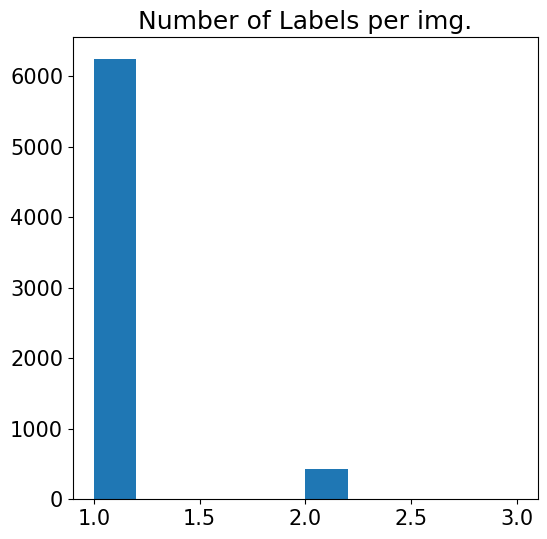

In [35]:
fig, ax = plt.subplots(figsize=(6,6))
ax.hist(df_grBy)
ax.set_title('Number of Labels per img.')

In [36]:
print(df_grBy.mean())
print(df_grBy.max())

1.0643564356435644
3


In [37]:
defect1 = class_by_1.EncodedPixels.count()
defect2 = class_by_2.EncodedPixels.count()
defect3 = class_by_3.EncodedPixels.count()
defect4 = class_by_4.EncodedPixels.count()
print(defect1)
print(defect2)
print(defect3)
print(defect4)

897
247
5150
801


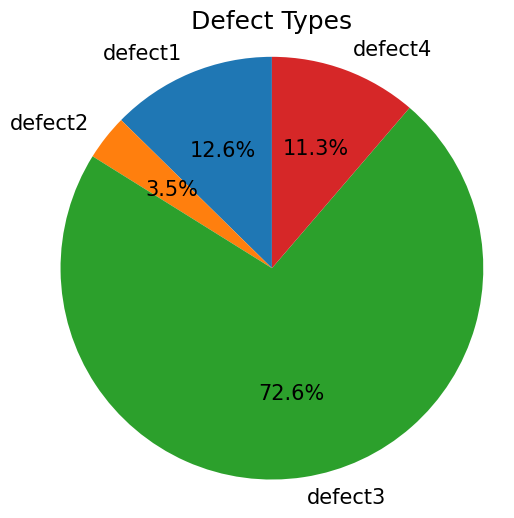

In [38]:
labels = 'defect1', 'defect2', 'defect3', 'defect4'
sizes = [defect1, defect2, defect3, defect4]
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
ax.set_title('Defect Types')
plt.show()

##Checking how each defects look like.

##RLE(Running Length Encoding), decode and draw.

1.decoding(string --> int array)

2.make 1d img --> 2d img

3.draw on the original img

##1. decoding(string --> int, array)

In [39]:
enco1_str = train_df.EncodedPixels[0]
enco1_str

'29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53 89283 40 89539 32 89667 10 89795 30 89923 28 90050 29 90179 37 90306 27 90434 38 90562 14 90690 38 90817 9 90946 38 91073 3 91202 38 91458 38 91714 38 91969 39 92225 39 92481 39 92737 39 92993 39 93248 40 93504 40 93760 40 94026 30 94302 10 189792 7 190034 21 190283 28 190539 28 190795 28 191051 28 191307 28 191563 28 191819 28 192075 28 192331 28 192587 28 192843 23 193099 14 193355 5'

In [40]:
enco1_arr = enco1_str.split(' ')
enco1_arr[:10]

['29102', '12', '29346', '24', '29602', '24', '29858', '24', '30114', '24']

In [41]:
enco1_pos = map(int, enco1_arr[0::2])
enco1_len = map(int, enco1_arr[1::2])

In [42]:
enco1_pos

In [43]:
temp_pos = list(enco1_pos)
temp_len = list(enco1_len)

In [44]:
temp_pos[:10]

[29102, 29346, 29602, 29858, 30114, 30370, 30626, 30882, 31139, 31395]

In [45]:
temp_len[:10]

[12, 24, 24, 24, 24, 24, 24, 24, 23, 23]

In [46]:
enco1_pos = map(int, enco1_arr[0::2])
enco1_len = map(int, enco1_arr[1::2])

In [47]:
for po, le in zip(enco1_pos, enco1_len):
    print(po, '<---->',le)

29102 <----> 12
29346 <----> 24
29602 <----> 24
29858 <----> 24
30114 <----> 24
30370 <----> 24
30626 <----> 24
30882 <----> 24
31139 <----> 23
31395 <----> 23
31651 <----> 23
31907 <----> 23
32163 <----> 23
32419 <----> 23
32675 <----> 23
77918 <----> 27
78174 <----> 55
78429 <----> 60
78685 <----> 64
78941 <----> 68
79197 <----> 72
79452 <----> 77
79708 <----> 81
79964 <----> 85
80220 <----> 89
80475 <----> 94
80731 <----> 98
80987 <----> 102
81242 <----> 105
81498 <----> 105
81754 <----> 104
82010 <----> 104
82265 <----> 105
82521 <----> 31
82556 <----> 69
82779 <----> 27
82818 <----> 63
83038 <----> 22
83080 <----> 57
83297 <----> 17
83342 <----> 50
83555 <----> 13
83604 <----> 44
83814 <----> 8
83866 <----> 37
84073 <----> 3
84128 <----> 31
84390 <----> 25
84652 <----> 18
84918 <----> 8
85239 <----> 10
85476 <----> 29
85714 <----> 47
85960 <----> 57
86216 <----> 57
86471 <----> 58
86727 <----> 58
86983 <----> 58
87238 <----> 59
87494 <----> 59
87750 <----> 59
88005 <----> 60
88261

##2. make 1d img --> 2d img

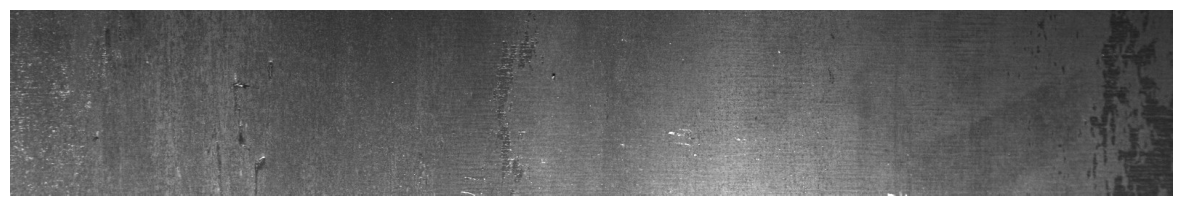

In [48]:
img1 = cv2.imread(train_fp[0])
fig, ax = plt.subplots(figsize=(15,5))
ax.axis('off')
ax.imshow(img1)
plt.show()

In [49]:
print(train_fp[0])
TRAIN_IMGS_PATH + train_df.ImageId[0]

/content/severstal steel defect detection/train_images/0002cc93b.jpg


'/content/severstal steel defect detection/train_images/0002cc93b.jpg'

In [50]:
print(train_fp[3])
TRAIN_IMGS_PATH + train_df.ImageId[3]

/content/severstal steel defect detection/train_images/000789191.jpg


'/content/severstal steel defect detection/train_images/000f6bf48.jpg'

In [51]:
print(img1.shape)

(256, 1600, 3)


In [52]:
mask_1d = np.zeros(img1.shape[0] * img1.shape[1], dtype=np.uint8)

In [53]:
enco1_pos = map(int, enco1_arr[0::2])
enco1_len = map(int, enco1_arr[1::2])

In [54]:
print(mask_1d.sum())
for po, le in zip(enco1_pos, enco1_len):
    mask_1d[po:po+le-1]=255

0


In [55]:
mask_1d.sum()

1093440

In [56]:
mask2d = mask_1d.reshape(img1.shape[0], img1.shape[1], order='F')

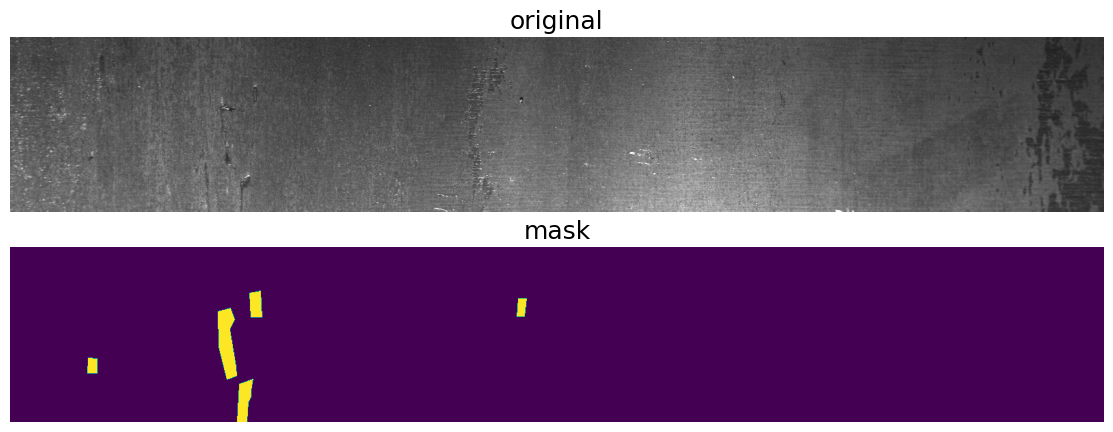

In [57]:
fig, ax = plt.subplots(2,1, figsize=(15,5))

ax[0].axis('off')
ax[0].set_title('original')
ax[0].imshow(img1)

ax[1].axis('off')
ax[1].set_title('mask')
ax[1].imshow(mask2d)

##3. draw on the original img

In [58]:
mask_contour, hier_ = cv2.findContours(mask2d, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

print(len(mask_contour))

5


In [59]:
len(mask_contour[0])

151

In [60]:
for i in range(len(mask_contour)):
    img1_poly = cv2.polylines(img1, mask_contour[i], True, (255,100,0), 2, cv2.LINE_AA)

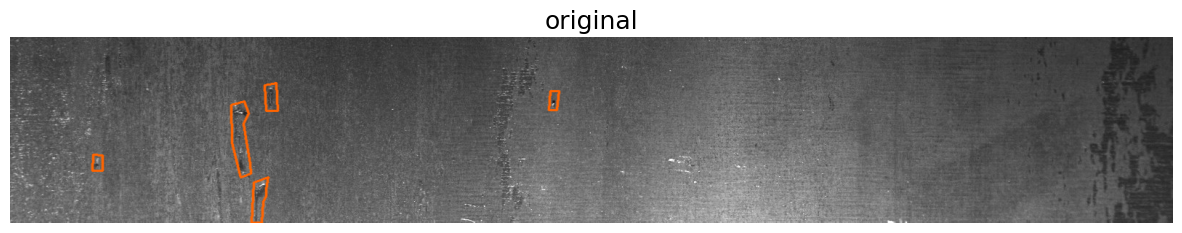

In [61]:
fig, ax = plt.subplots(figsize=(15,5))

ax.axis('off')
ax.set_title('original')
ax.imshow(img1_poly)

For some reason, regardless of the isClosed parameter value in the polylines function, the function was not creating closed contours. Therefore, instead of approximating the contours using the findContours function, all contour points were extracted and used to draw the contours. This approach may not be computationally efficient, but it is easy to understand, so it was used instead.

In summary, the code was modified to extract all contour points instead of approximating them and drawing the contours using polylines.

Now, we will create a function using the previous steps, which can be used for repetitive tasks.

Input: file path, encoded array data.

Output: display an image with masks.

In [62]:
def decode_PosLen(encodedStr):
    str_encodedArr = encodedStr.split(" ")
    
    int_posArr = map(int, str_encodedArr[0::2])
    int_lenArr = map(int, str_encodedArr[1::2])
    
    return int_posArr, int_lenArr

In [63]:
def getcontourArr(imgShape, int_posArr, int_lenArr):
    # imgShape : tuple data
    # int_posArr, int_lenArr >> map 상태이다.
    int_contourArr = []
    
    # 1d img
    maskOneD = np.zeros(imgShape[0]*imgShape[1], dtype=np.uint8)
    for po, le in zip(int_posArr, int_lenArr):
        maskOneD[po:po+le-1] = 255
    
    # reshape 1d to 2d
    mask = maskOneD.reshape(imgShape[0], imgShape[1], order='F')
    
    # get contour pixels
    int_contourArr, hier_ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    return int_contourArr

In [64]:
def show_mask(dfRow):
    
    
    imgID = train_df.ImageId[dfRow] 
    encodedStr = train_df.EncodedPixels[dfRow]
    classID = train_df.ClassId[dfRow]
    
    
    # read img.
    str_imgPath = TRAIN_IMGS_PATH + imgID
    img = cv2.imread(str_imgPath)
    if img is None:
        print("img is empty.")
        return -1
    
    # decode str_encodArr to int_decodeArr, position and length
    int_posArr, int_lenArr = decode_PosLen(encodedStr)
    
    # extract mask contour pixel data.
    int_contourArr = getcontourArr(img.shape ,int_posArr, int_lenArr) 

    # draw the pixels on origianl img.
    for i in range(len(int_contourArr)):
        img_poly = cv2.polylines(img, int_contourArr[i], True, (255,100,0), 2, cv2.LINE_AA)
    
    # plot img
    fig, ax = plt.subplots(figsize=(15,5))
    ax.axis('off')
    ax.set_title("CLASS ID : " + str(classID) +" -------------- IMG ID : "+ imgID)
    ax.imshow(img_poly)
    
    return None

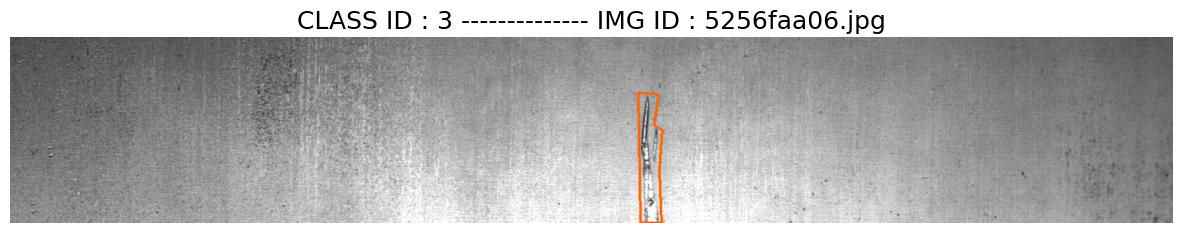

In [65]:
dfRow = 2222
show_mask(dfRow)

In [66]:
df_grBy[df_grBy==3]

ImageId
db4867ee8.jpg    3
ef24da2ba.jpg    3
Name: EncodedPixels, dtype: int64

In [67]:
train_df[train_df.ImageId == "db4867ee8.jpg"]

ImageId  ClassId  \
6101  db4867ee8.jpg        1   
6102  db4867ee8.jpg        2   
6103  db4867ee8.jpg        3   

                                          EncodedPixels  
6101  349941 2 350194 6 350447 11 350700 15 350953 1...  
6102  354411 17 354634 50 354857 82 355096 99 355351...  
6103                              233729 3008 236801 64

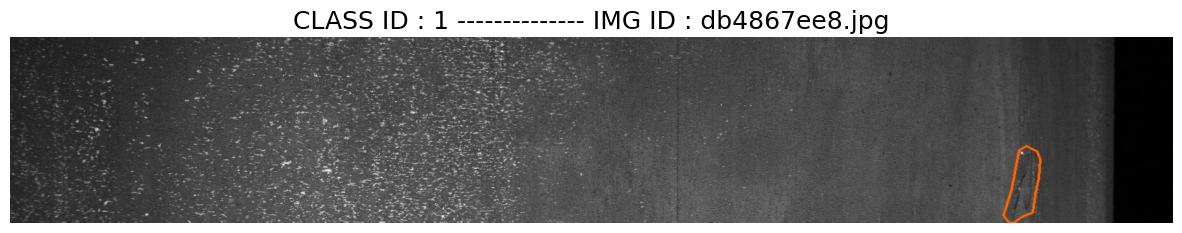

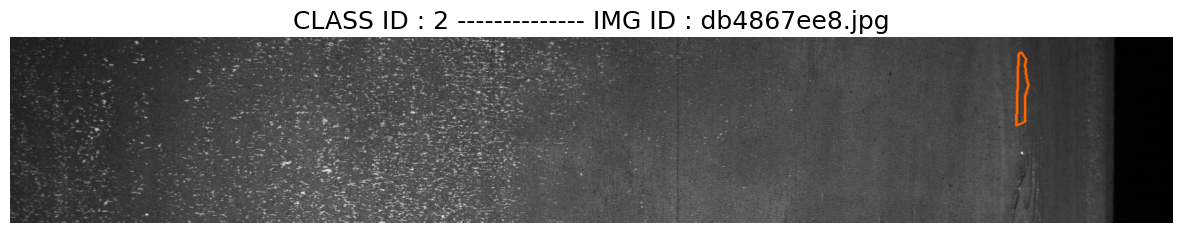

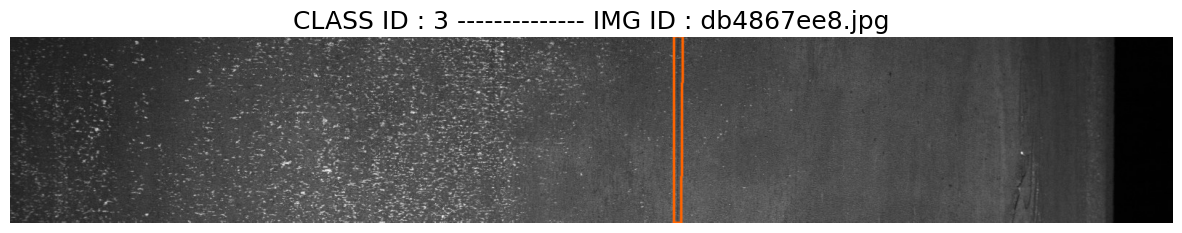

In [68]:
for dfRow in range(6101, 6104):
    show_mask(dfRow)

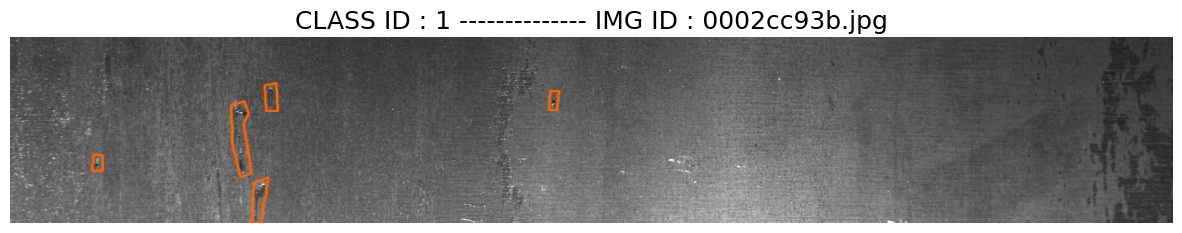

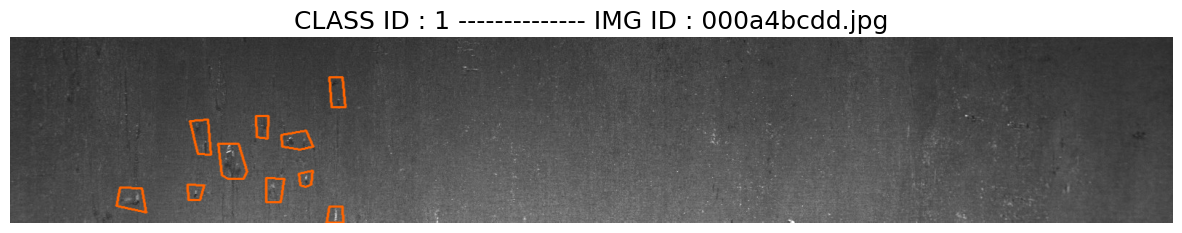

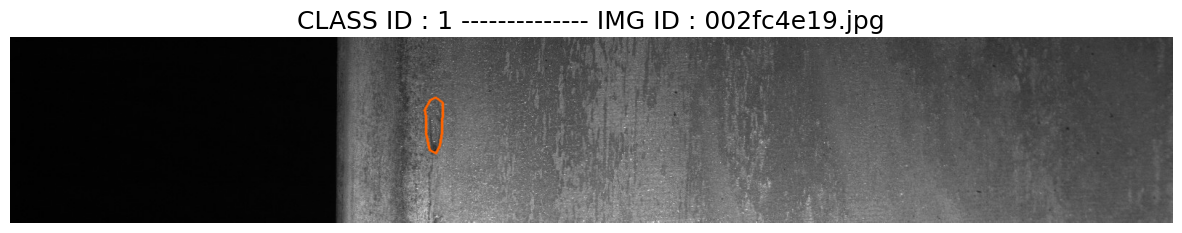

In [69]:
for dfRow in class_by_1.index[:3]:
    show_mask(dfRow)

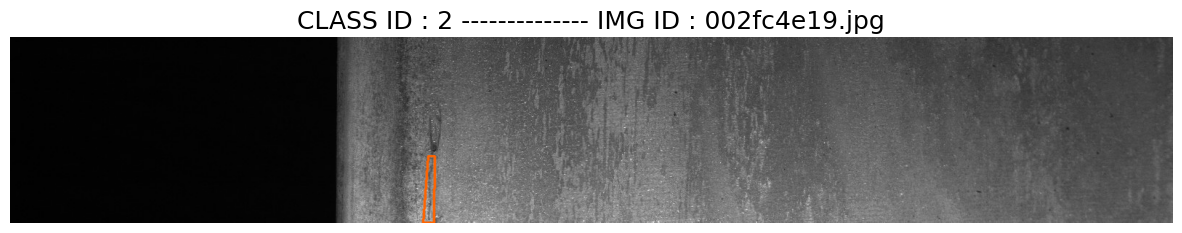

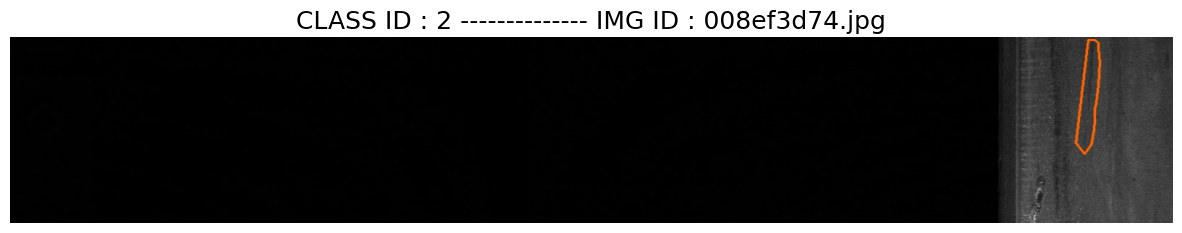

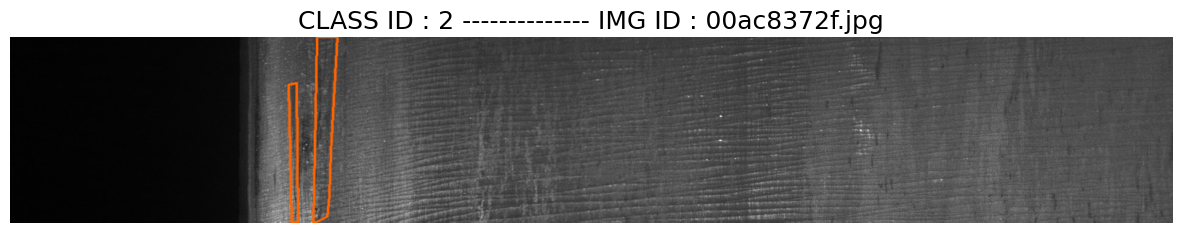

In [70]:
for dfRow in class_by_2.index[:3]:
    show_mask(dfRow)

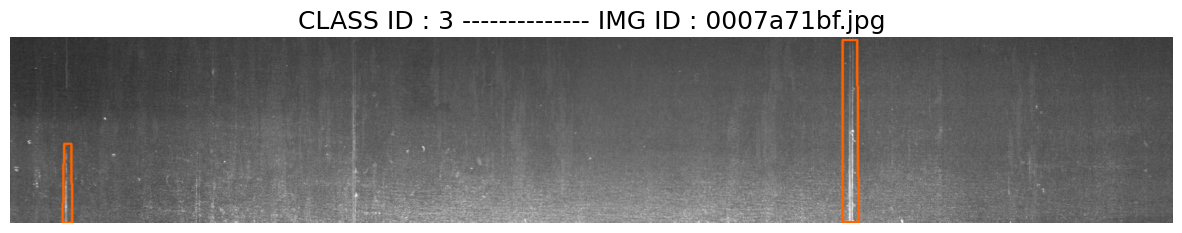

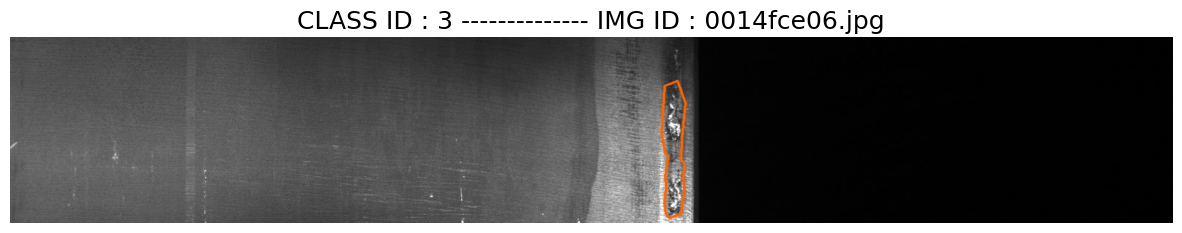

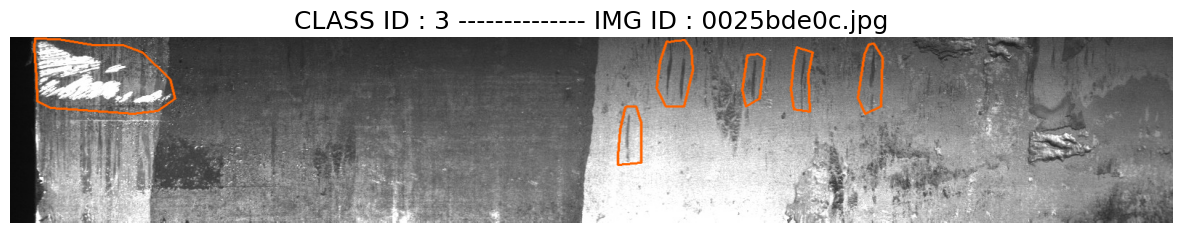

In [71]:
for dfRow in class_by_3.index[:3]:
    show_mask(dfRow)

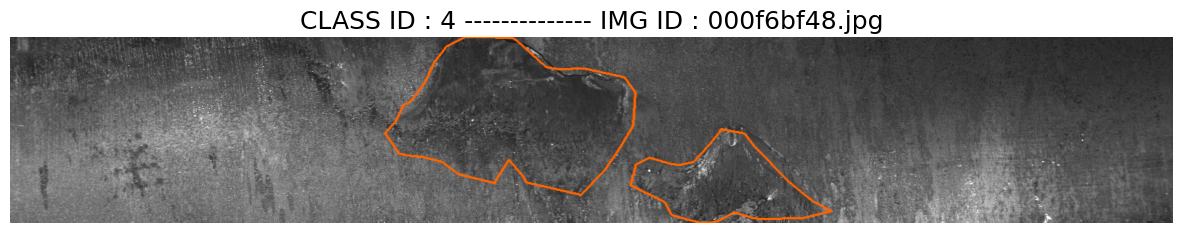

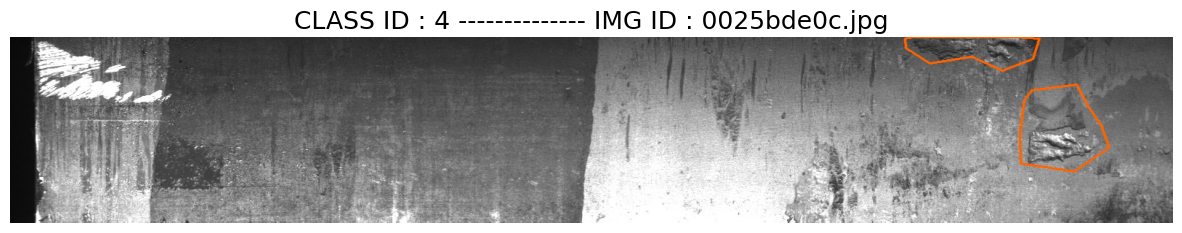

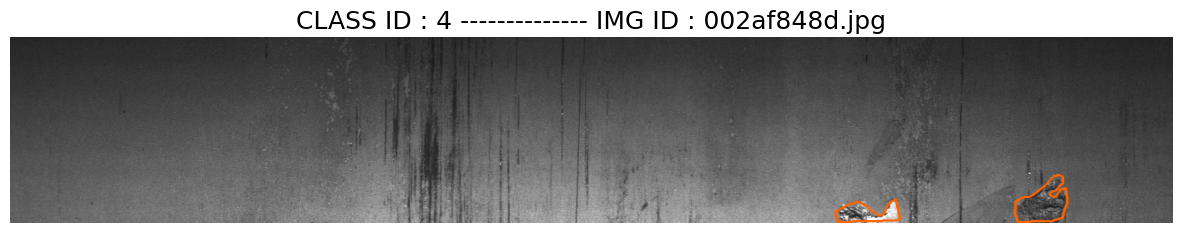

In [72]:
for dfRow in class_by_4.index[:3]:
    show_mask(dfRow)

In [113]:
l1=[]
l2=[] 
for img,ClassId,EncodedPixels in tqdm(train_df.values):
    image=cv2.imread("/content/severstal steel defect detection/train_images/{}".format(img),cv2.IMREAD_COLOR)
    image=cv2.resize(image,(120,120))
    l1.append(image)
    l2.append(ClassId)

100%|██████████| 7095/7095 [00:40<00:00, 176.61it/s]


In [116]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = to_categorical(y)

In [118]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)
print("x_train shape:",X_train.shape)
print("x_test shape:",X_val.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_val.shape)

x_train shape: (5676, 120, 120, 3)
x_test shape: (1419, 120, 120, 3)
y_train shape: (5676, 4)
y_test shape: (1419, 4)


In [87]:
base_model = tf.keras.applications.Xception(input_shape=(120,120,3),include_top=False,weights="imagenet")

83683744/83683744 [==============================] - 4s 0us/step


In [88]:
for layer in base_model.layers[:-5]:
    layer.trainable=False

In [89]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))

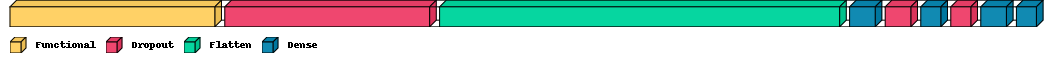

In [107]:
visualkeras.layered_view(model, legend=True)

In [90]:
# Model Summary

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 dropout_3 (Dropout)         (None, 4, 4, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)              

In [92]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
]

In [98]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 1,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [99]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [120]:
%time
history = model.fit(X_train,y_train,epochs=20,validation_data=(X_val,y_val),batch_size=128,verbose=1,callbacks=[lrd,mcp,es])

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
Epoch 1/20
45/45 [==============================] - 12s 264ms/step - loss: 0.3915 - accuracy: 0.9202 - precision: 0.8567 - recall: 0.8175 - auc: 0.9718 - val_loss: 0.5141 - val_accuracy: 0.9063 - val_precision: 0.8198 - val_recall: 0.8013 - val_auc: 0.9579 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 0.3291 - accuracy: 0.9315 - precision: 0.8765 - recall: 0.8451 - auc: 0.9796
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
45/45 [==============================] - 11s 252ms/step - loss: 0.3291 - accuracy: 0.9315 - precision: 0.8765 - recall: 0.8451 - auc: 0.9796 - val_loss: 0.6207 - val_accuracy: 0.8957 - val_precision: 0.7951 - val_recall: 0.7851 - val_auc: 0.9509 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 0.2501 - accuracy: 0.9461 - precision: 0.9030 - recall: 0.8788 - auc: 0.9881
Epoch 3: ReduceLROnPlateau reducing learn

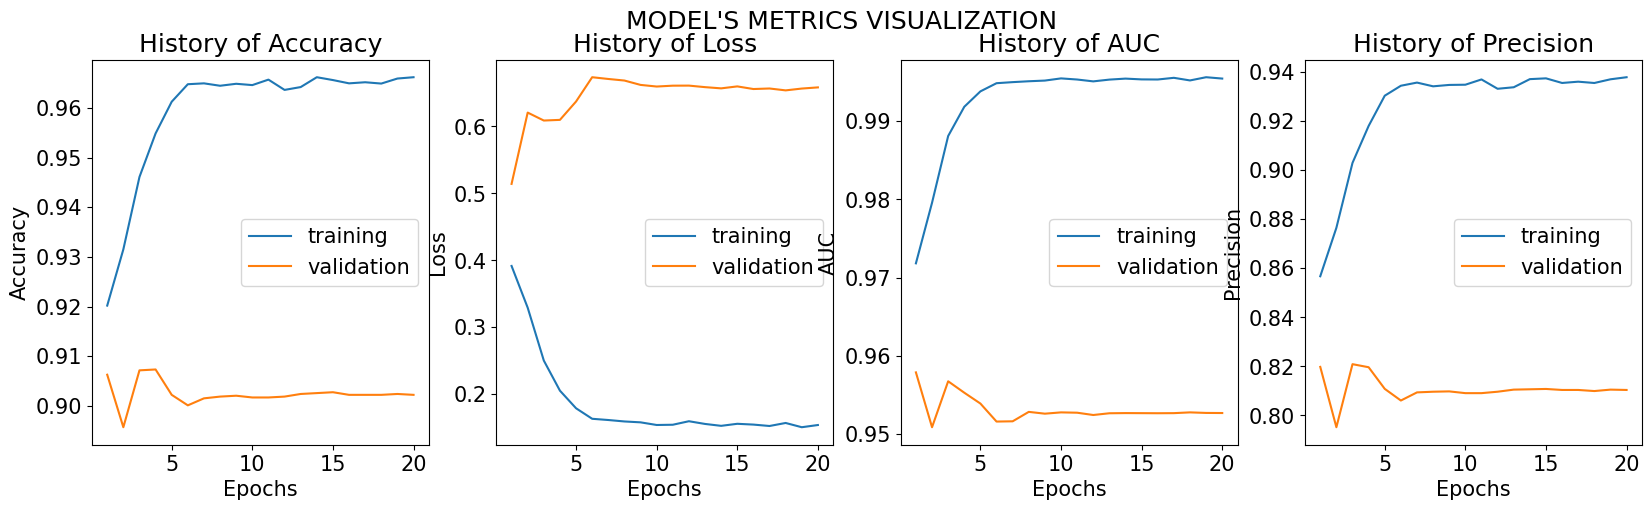

In [126]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision']
              )


In [ ]:
# Set the image size for resizing
IMG_SIZE = (120, 120)

# Get the path to the folder containing the test images
test_folder = '/content/severstal steel defect detection/test_images'

# Get a list of all image files in the test folder
image_files = [os.path.join(test_folder, f) for f in os.listdir(test_folder) if f.endswith('.jpg')]

# Loop through each image file
for image_file in image_files:
    # Read the image file
    img = cv2.imread(image_file, cv2.IMREAD_COLOR)

    # Resize the image
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)

    # Convert the image to a numpy array
    img = np.array(img)

    # Reshape the image to match the input shape of the model
    img = np.reshape(img, (1, IMG_SIZE[0], IMG_SIZE[1], 3))

    # Normalize the image data
    img = img / 255.0

    # Predict using the trained model
    pred = model.predict(img)

    # Do something with the prediction result, for example print the class with the highest probability
    pred_class = np.argmax(pred, axis=1)
    print(f"Prediction for {image_file}: {pred_class}")


In [144]:
def preprocess_image(image, target_size):
    # Resize the image to the target size
    image = cv2.resize(image, target_size)
    
    # Convert the color space from RGB to BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # Normalize the pixel values to the range [0, 1]
    image = image.astype(np.float32) / 255.0
    
    # Expand the dimensions of the image to match the input shape of the model
    image = np.expand_dims(image, axis=0)
    
    return image


In [ ]:
# Create an empty dataframe to store the predictions
predictions_df = pd.DataFrame(columns=['image_name', 'prediction'])

# Set the path to the folder containing the test images
images_folder = '/content/severstal steel defect detection/test_images'

# Loop through all the images in the folder
for image_name in os.listdir(images_folder):

    # Load the image
    image_path = os.path.join(images_folder, image_name)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Resize the image
    image = cv2.resize(image, (120, 120), interpolation=cv2.INTER_AREA)

    # Preprocess the image
    image = preprocess_image(image, (120,120))

    # Make a prediction
    prediction = model.predict(image)

    # Append the prediction to the dataframe
    predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)

# Print the dataframe
print(predictions_df)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 47ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 48ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 46ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 48ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 96ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 127ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 52ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 50ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 47ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 50ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 51ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 53ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 60ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 62ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 51ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 47ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 46ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 69ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 70ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 54ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 47ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 51ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 63ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 63ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 57ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 74ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 64ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 51ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 51ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 69ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 65ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 46ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 62ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 57ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 50ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 77ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 65ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 54ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 64ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 73ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 55ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 54ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 56ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 51ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 56ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 63ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 52ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 65ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 62ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 47ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 48ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 50ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 64ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 48ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 63ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 48ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 53ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 60ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 67ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 59ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 50ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 69ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 67ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 59ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 77ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 55ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 58ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 51ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 50ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 67ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 70ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 72ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 76ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 48ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 67ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 70ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 56ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 48ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 50ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 60ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 56ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 62ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 53ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 71ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 60ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 52ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 63ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 55ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 69ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 51ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 54ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 66ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 47ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 47ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 60ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 70ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 74ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 60ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 73ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 64ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 59ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 66ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 64ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 46ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 67ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 58ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 47ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 50ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 66ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 53ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 47ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 66ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 50ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 58ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 62ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 66ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 48ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 61ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 54ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 75ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 64ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 46ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 53ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 60ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 85ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 57ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 52ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 70ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 60ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 53ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 59ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 46ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 46ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 51ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 52ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 59ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 70ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 65ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 74ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 74ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 65ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)
<ipython-input-146-b15ac747d461>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'image_name': image_name, 'prediction': prediction}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step
